## Install Requirements

In [1]:
!pip install transformers
!pip install sentencepiece
!pip install lmppl
!pip install datasets
!pip install --force-reinstall protobuf==3.20.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 52.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 38.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 102.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 79.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 10.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 74.4 MB/s eta 0:00:00
  Created wheel for lmppl: filename=lmppl-0.3.1-py3-none-any.whl size=13113 sha256=191aef3d5cb6cf4f9b1292d0a4e072db78e87e148bcf1ac24173554888834bf9
  Stored in directory: /root/.cache/pip/wheels/c2/19/b5/3ff20891be9a8cb50595b6d4d37b819be0cbe71ddcea9ac10c
Successfully built lmppl
  Attempting uninstall: protobuf
    Fou

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 518.9/518.9 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.3 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.6
    Uninstalling protobuf-3.19.6:
      Successfully uninstalled protobuf-3.19.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-api-core 2.11.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0.dev0,>=3.19.5, but you have protobuf 3.20.1 which is incompatible.
google-cloud-bigquery 3.10.0 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,

In [2]:
!git clone https://github.com/jwkirchenbauer/lm-watermarking.git

Cloning into 'lm-watermarking'...
remote: Enumerating objects: 313, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 313 (delta 10), reused 5 (delta 5), pack-reused 288
Receiving objects: 100% (313/313), 11.98 MiB | 9.12 MiB/s, done.
Resolving deltas: 100% (87/87), done.


In [30]:
%load_ext autoreload
%autoreload 2

In [1]:
import sys
sys.path.insert(0, "/content/watermark_language_models")

## CNN dataset

In [11]:
from datasets import load_dataset

In [12]:
ds = load_dataset('cnn_dailymail', '3.0.0')

In [13]:
articles = [d['article'] for d in ds['train']]
summaries = [d['highlights'] for d in ds['train']]

In [14]:
len(articles) == len(summaries)

True

## Run expriments

In [1]:
!git clone https://github.com/pouya-parsa/watermark_language_models.git

Cloning into 'watermark_language_models'...
remote: Enumerating objects: 42, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 42 (delta 16), reused 36 (delta 10), pack-reused 0
Receiving objects: 100% (42/42), 395.39 KiB | 17.97 MiB/s, done.
Resolving deltas: 100% (16/16), done.


In [15]:
import numpy as np

In [16]:
np.random.seed(42)
idx = np.random.choice(len(articles), 1_000, replace=False)
idx

array([272581,    772, 171868,  63167,  68522,  81888,  64374,   3425,
        74122, 207965, 209080, 131862, 275884, 150335, 277076, 135896,
       222229, 164294, 271501,  98483, 116314, 258665,  27906, 238624,
       285857, 116191,   7588, 110438, 137976, 275578, 137193, 240723,
       165626, 282569, 119592, 171339, 100152, 189929, 123984, 179115,
       224845,  30489,  49267, 193549,  74687, 149451,  78787, 198294,
       217566, 214898,  42460, 243039,  17884,  84554,  57661, 228573,
        10347,  54262, 236103,  63766,  20546, 249229,  68937, 126132,
       228972,  51909, 255614, 270437, 114625, 134894,   3913,  52630,
       197398, 118890, 276021, 130203, 246004,  60813,  48207, 146650,
        67071, 137651, 246640, 272925, 228082,  42261, 248001,  64351,
       224196,  92081, 156154, 158791, 112405,  78348, 176709,  18797,
       128133,  94921, 212561, 169584,  24707, 278619,  32019, 119685,
       268401, 176003,  83735, 177293, 107981, 228780, 155719, 162841,
      

In [17]:
sampled_articles = [articles[i] for i in idx]
sampled_summaries = [summaries[i] for i in idx]

In [2]:
import sys
sys.path.insert(0, "/content/watermark_language_models")

In [7]:
import pickle
from tqdm.auto import tqdm
from summarizer import summarize, tokenizer

You are using the legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This means that tokens that come after special tokens will not be properly handled. We recommend you to read the related pull request available at https://github.com/huggingface/transformers/pull/24565


In [ ]:
# text = """
# The tower is 324 metres (1,063 ft) tall, about the same height as an 81-storey building, and the tallest structure in Paris.
#  Its base is square, measuring 125 metres (410 ft) on each side. It was the first structure to reach a height of 300 metres.
#   Excluding transmitters, the Eiffel Tower is the second tallest free-standing structure in France after the Millau Viaduct.
# """
# watermarked_summary = summarize(text, watermark=True)
# print(watermarked_summary)
# normal_summary = summarize(text, watermark=False)
# print(normal_summary)

In [11]:
delta_gamma = [
    (5.0, 0.1), (5.0, 0.25), (5.0, 0.5), (5.0, 0.75), (5.0, 0.9),
    (10, 0.25), (5.0, 0.25), (2.0, 0.25), (1.0, 0.25), (0.5, 0.25)
]


for (delta, gamma) in delta_gamma:
    print(f"gamma is {gamma} and delta is {delta} \n")
    watermarked_sum = []
    not_watermarked_sum = []
    for article in tqdm(sampled_articles):
      watermarked_sum.append(summarize(article, watermark=True))
      # not_watermarked_sum.append(summarize(article, watermark=False))

    filename = f"gamma_{gamma}_delta_{delta}.pickle"
    with open(filename, "wb") as f:
      pickle.dump({
          "watermarked": watermarked_sum,
          # "not_watermarked_sum": not_watermarked_sum
    }, f)

gamma is 0.25 and delta is 0.5 



  0%|          | 0/1000 [00:00<?, ?it/s]

## Average z-score as a function of T the token length of the generated text figure

In [3]:
from utils import WatermarkDetectorClass
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_theme()

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1714: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:2193: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


In [19]:
gamma_values = [0.25]
delta_values = [10, 5.0, 2.0, 1.0, 0.5]

In [17]:
from collections import defaultdict

class AverageDict(defaultdict):
    def __init__(self):
        super().__init__(list)

    def add(self, key, value):
        self[key].append(value)
        self.get_avg(key)

    def get_avg(self, key):
        values = self[key]
        self[key] = sum(values) / len(values)
        return self[key]

In [16]:
def log_fit(x, y):
  from scipy.optimize import curve_fit
  def log_func(x, a, b):
      return a * np.log(b*x)
  popt, pcov = curve_fit(log_func, x, y)
  y_fit = log_func(x, popt[0], popt[1])
  return y_fit

gamma is 0.25 and delta is 10 



<ipython-input-16-ed3481ae2522>:4: RuntimeWarning: invalid value encountered in log
  return a * np.log(b*x)


gamma is 0.25 and delta is 5.0 

gamma is 0.25 and delta is 2.0 

gamma is 0.25 and delta is 1.0 

gamma is 0.25 and delta is 0.5 



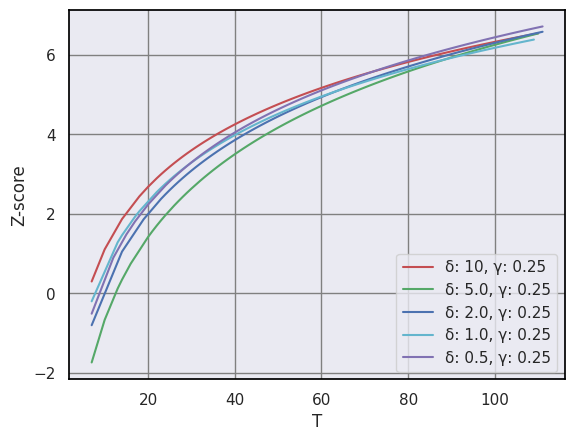

In [25]:
# fig, ax = plt.subplots()
i = 0
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'darkorange', 'hotpink', 'limegreen']
for gamma in gamma_values:
  for delta in delta_values:
    print(f"gamma is {gamma} and delta is {delta} \n")
    watermark_detector = WatermarkDetectorClass(tokenizer, gamma, "cuda")
    with open(f"gamma_{gamma}_delta_{delta}.pickle", "rb") as f:
      watermarked_outputs = pickle.load(f)["watermarked"]
    data_points = AverageDict()
    for output in watermarked_outputs:
      score_dict = watermark_detector.detect(output)
      z_value = score_dict["z_score"]
      token_length = score_dict["num_tokens_scored"]
      data_points[token_length] = z_value

    data_points = dict(data_points)
    data_points = sorted(data_points.items(), key=lambda x: x[0])
    data_points = dict(data_points)
    x = np.array(list(data_points.keys()))
    y = np.array(list(data_points.values()))
    y_log = log_fit(x, y)
    plt.plot(data_points.keys(), y_log, label=f'δ: {delta}, γ: {gamma}', c=colors[i], antialiased=True)
    i += 1

plt.xlabel("T")
plt.ylabel("Z-score")
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['grid.color'] = 'gray'
plt.grid(True)
plt.legend()
plt.show()

## Tradeoff between average z-score and language model perplexity figure

In [8]:
from utils import get_perplexity

In [9]:
delta_gamma = [
    (5.0, 0.1), (5.0, 0.25), (5.0, 0.5), (5.0, 0.75), (5.0, 0.9),
    (10, 0.25), (5.0, 0.25), (2.0, 0.25), (1.0, 0.25), (0.5, 0.25)
]

In [18]:
info = {}
for (delta, gamma) in delta_gamma:
    print(f"gamma is {gamma} and delta is {delta} \n")
    watermark_detector = WatermarkDetectorClass(tokenizer, gamma, "cuda")
    with open(f"gamma_{gamma}_delta_{delta}.pickle", "rb") as f:
      watermarked_outputs = pickle.load(f)["watermarked"]
    z_scores = []
    ppl_scores = []
    for i, index in enumerate(idx):
      score_dict = watermark_detector.detect(watermarked_outputs[i])
      input_text = "summarize: " + articles[index]
      output_text = watermarked_outputs[i]
      ppl_score = get_perplexity([input_text], [output_text])
      z_scores.append(score_dict["z_score"])
      ppl_scores.append(ppl_score)
    info[f"gamma_{gamma}_delta_{delta}"] = {"z_score": np.mean(z_scores), "ppl_score": np.mean(ppl_scores)}

gamma is 0.1 and delta is 5.0 

gamma is 0.25 and delta is 5.0 

gamma is 0.5 and delta is 5.0 

gamma is 0.75 and delta is 5.0 

gamma is 0.9 and delta is 5.0 

gamma is 0.25 and delta is 10 

gamma is 0.25 and delta is 5.0 

gamma is 0.25 and delta is 2.0 

gamma is 0.25 and delta is 1.0 

gamma is 0.25 and delta is 0.5 



In [19]:
import pickle
with open("info.pickle", "wb") as f:
  pickle.dump(info, f)

<ipython-input-24-487fde06a093>:13: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r*" (-> color='r'). The keyword argument will take precedence.
  plt.plot(data["ppl_score"], data["z_score"], symbol[str(delta)], markersize=12, label=f'δ: {delta}, γ: {gamma}', c=colors[i])


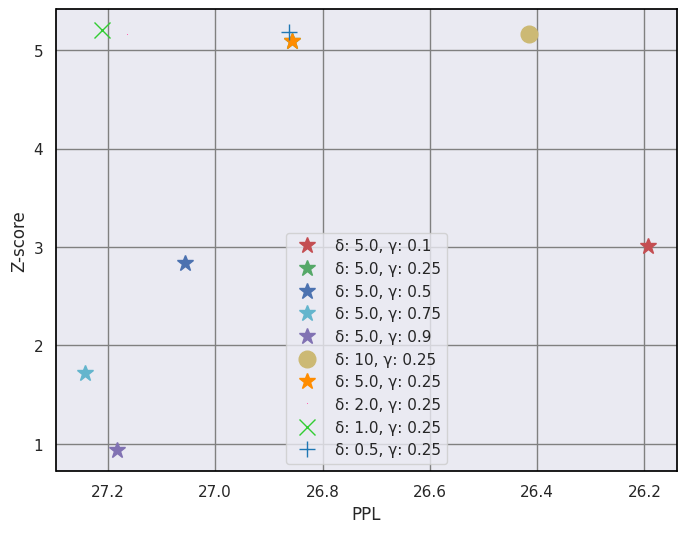

In [24]:
i = 0
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'darkorange', 'hotpink', 'limegreen', '#1f77b4']
symbol = {
    "10": "o",
    "5.0": "r*",
    "2.0": ",",
    "1.0": "x",
    "0.5": "+"
}
fig, ax = plt.subplots(figsize=(8,6))
for (delta, gamma) in delta_gamma:
      data = info[f"gamma_{gamma}_delta_{delta}"]
      plt.plot(data["ppl_score"], data["z_score"], symbol[str(delta)], markersize=12, label=f'δ: {delta}, γ: {gamma}', c=colors[i])
      i += 1

plt.xlabel("PPL")
plt.ylabel("Z-score")
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['grid.color'] = 'gray'
plt.grid(True)
plt.legend()
ax.xaxis.set_inverted(True)
plt.show()